In [4]:
from tslearn.utils import to_time_series_dataset
import json
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import os
label_df = pd.read_csv('/home/woody/iwso/iwso092h/empkins/notebooks/labels.csv')
parent_dir = '/home/vault/empkins/tpD/D02/Students/Aditya/facau_data'
ids = os.listdir(parent_dir)
ids = os.listdir(parent_dir)

numeric_ids = [id for id in ids if id.isdigit()]

In [5]:
valid_ids = []
coping_list = []

ids = os.listdir(parent_dir)
for id in ids:
    target_path = os.path.join(parent_dir, str(id), 'ei.json')
    if os.path.isfile(target_path):  # Check if the file exists
        try:
            with open(target_path, 'r') as f:
                coping_data = json.load(f)
            df = pd.DataFrame.from_dict(coping_data)
            if not df.empty:
                coping_list.append(df)
                valid_ids.append(int(id))  # Add valid ID to the list
        except (FileNotFoundError, ValueError, json.JSONDecodeError):
            pass

id_df = pd.DataFrame({'Participant ID': valid_ids})

# label_df = pd.read_csv('path_to_label_file.csv')  # Replace with the actual path
label_df['Participant ID'] = label_df['Participant ID'].astype(int)

# Merge combined_df with id_df to rearrange according to the directory IDs
reordered_df = id_df.merge(label_df, on='Participant ID', how='left')
y = reordered_df['Label']
y = pd.Series(y)
if y.isna().sum() > 0:
    y.fillna(y.mode()[0], inplace=True)
y = y.apply(lambda x: 0 if x == 0.5 else x).astype(int)

# Step 2: Filter columns for Happiness and Sadness
columns_to_include_happiness = ['fac_AU01int', 'fac_AU04int']
columns_to_include_sadness = ['fac_AU01int', 'fac_AU04int', 'fac_AU15int']

coping_list_happiness = [df[columns_to_include_happiness] for df in coping_list]
coping_list_sadness = [df[columns_to_include_sadness] for df in coping_list]

# Remove empty dataframes
coping_list_happiness = [df for df in coping_list_happiness if not df.empty]
coping_list_sadness = [df for df in coping_list_sadness if not df.empty]

# Step 3: Pad or Trim Dataframes
max_length_limit = 3000  
max_length = min(max(df.shape[0] for df in coping_list_happiness), max_length_limit)

def pad_or_trim_dataframe(df, max_length):
    if df.shape[0] > max_length:
        return df.iloc[:max_length].to_numpy()
    else:
        padding_length = max_length - df.shape[0]
        padding = np.zeros((padding_length, df.shape[1]))
        return np.vstack([df.to_numpy(), padding])

processed_arrays_happiness = [pad_or_trim_dataframe(df, max_length) for df in coping_list_happiness]
processed_arrays_sadness = [pad_or_trim_dataframe(df, max_length) for df in coping_list_sadness]

data_array_happiness = np.stack(processed_arrays_happiness, axis=1)
data_array_sadness = np.stack(processed_arrays_sadness, axis=1)

# Step 4: Normalize Data
scaler = StandardScaler()

def normalize_data_array(data_array):
    n_time_series, n_samples, n_features = data_array.shape
    data_array_reshaped = data_array.reshape(-1, n_features)
    data_array_normalized = scaler.fit_transform(data_array_reshaped)
    return data_array_normalized.reshape(n_time_series, n_samples, n_features)

data_array_normalized_happiness = normalize_data_array(data_array_happiness)
data_array_normalized_sadness = normalize_data_array(data_array_sadness)

# Step 5: Sum AU values for each emotion
reshaped_array_happiness = np.transpose(data_array_normalized_happiness, (1, 2, 0))
reshaped_array_sadness = np.transpose(data_array_normalized_sadness, (1, 2, 0))

summed_array_happiness = np.sum(reshaped_array_happiness, axis=1)
summed_array_sadness = np.sum(reshaped_array_sadness, axis=1)

# Ensure both arrays have the same shape
num_participants = min(len(summed_array_happiness), len(summed_array_sadness), 100)
summed_array_happiness = summed_array_happiness[:num_participants]
summed_array_sadness = summed_array_sadness[:num_participants]

# Step 6: Combine and reshape to (100, 2, 3000)
combined_array = np.stack([summed_array_happiness, summed_array_sadness], axis=1)

# Ensure the combined array has the desired shape
final_array = combined_array[:100, :, :max_length]

print(f"Final array shape: {final_array.shape}")

Final array shape: (100, 2, 3000)


In [16]:
final_array

array([[[-1.03600889, -1.10467489, -1.05889756, ..., -1.37933888,
         -1.37933888, -1.37933888],
        [-1.31377858, -1.28688407, -1.22199463, ..., -1.73355698,
         -1.73355698, -1.73355698]],

       [[ 3.08550845,  3.38358027,  3.47223596, ...,  1.64538315,
          1.55382848,  1.46227382],
        [ 5.46432101,  5.87706544,  6.11861795, ...,  3.45083263,
          3.09170853,  2.96192966]],

       [[-0.28470735, -0.20578692, -0.16342773, ..., -1.37933888,
         -1.37933888, -1.37933888],
        [-0.58158914, -0.52178082, -0.51764583, ..., -1.73355698,
         -1.73355698, -1.73355698]],

       ...,

       [[-0.02453823,  0.080689  ,  0.19906964, ...,  0.55421156,
          0.44898432,  0.48844453],
        [-0.37875634, -0.2735291 , -0.15514846, ...,  0.27644186,
          0.17121463,  0.21067484]],

       [[-0.78423357, -0.92156556, -0.92156556, ..., -1.37933888,
         -1.37933888, -1.37933888],
        [-1.06200326, -1.16111105, -1.16111105, ..., -1.73355

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(final_array, y, test_size=0.2, random_state=42, stratify=y)

In [18]:
from tsai.all import *
import sklearn.metrics as skm
X, y, splits = combine_split_data([X_train, X_test], [y_train, y_test])

In [19]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)

In [10]:
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], splits=splits, batch_tfms=[TSStandardize()], num_workers=0)

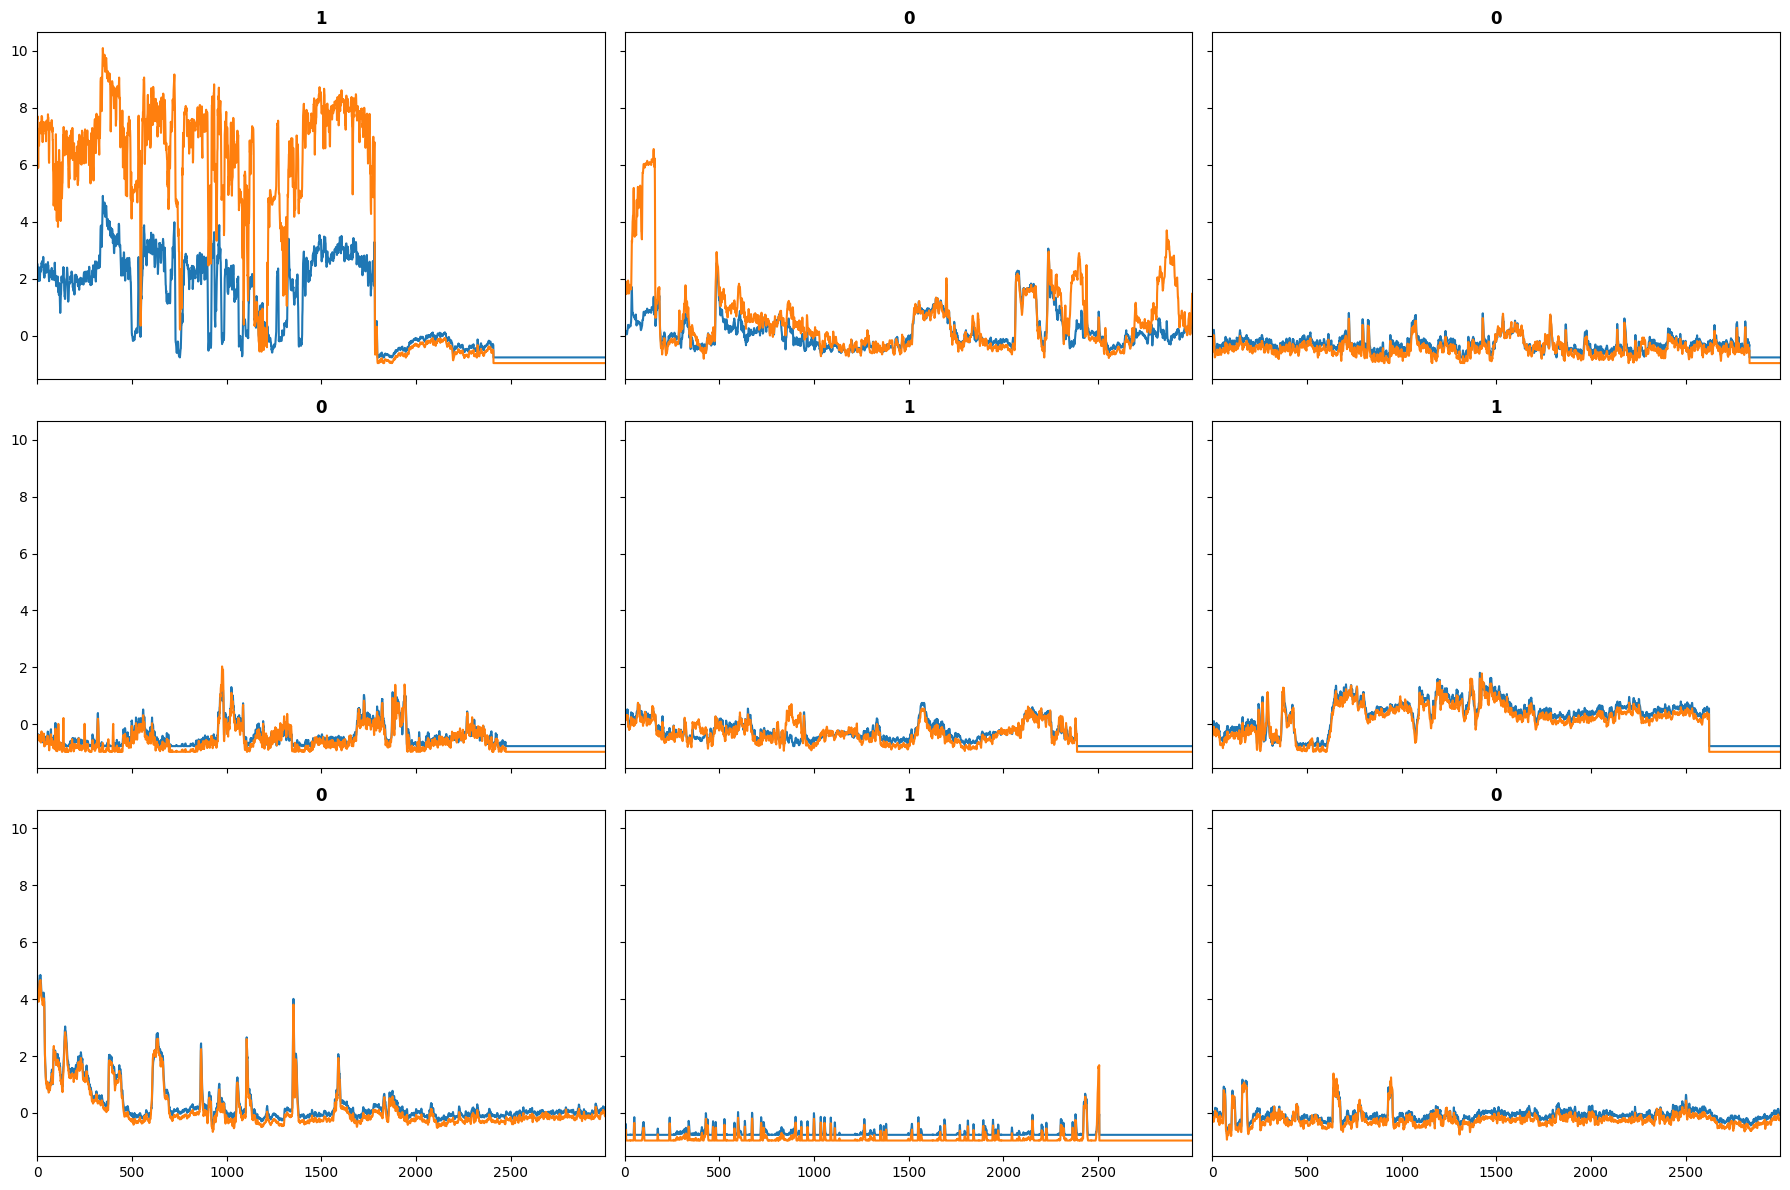

In [11]:
dls.show_batch(sharey=True)

In [20]:
dsets.train

(#80) [(TSTensor(vars:2, len:3000, device=cpu, dtype=torch.float32), TensorCategory(0)), (TSTensor(vars:2, len:3000, device=cpu, dtype=torch.float32), TensorCategory(1)), (TSTensor(vars:2, len:3000, device=cpu, dtype=torch.float32), TensorCategory(1)), (TSTensor(vars:2, len:3000, device=cpu, dtype=torch.float32), TensorCategory(1)), (TSTensor(vars:2, len:3000, device=cpu, dtype=torch.float32), TensorCategory(1)), (TSTensor(vars:2, len:3000, device=cpu, dtype=torch.float32), TensorCategory(0)), (TSTensor(vars:2, len:3000, device=cpu, dtype=torch.float32), TensorCategory(0)), (TSTensor(vars:2, len:3000, device=cpu, dtype=torch.float32), TensorCategory(1)), (TSTensor(vars:2, len:3000, device=cpu, dtype=torch.float32), TensorCategory(0)), (TSTensor(vars:2, len:3000, device=cpu, dtype=torch.float32), TensorCategory(1))] ...]

In [21]:
model = build_ts_model(ROCKET, dls=dls)

In [22]:
X_train, y_train = create_rocket_features(dls.train, model)
X_valid, y_valid = create_rocket_features(dls.valid, model)
X_train.shape, X_valid.shape

((64, 20000), (20, 20000))

 0 eps: 1.00E-06  C: 1.00E-05  loss: 0.66595  train_acc: 0.65625  valid_acc: 0.50000
 1 eps: 1.00E-06  C: 3.36E-05  loss: 0.64412  train_acc: 0.67188  valid_acc: 0.50000
 2 eps: 1.00E-06  C: 1.13E-04  loss: 0.59706  train_acc: 0.73438  valid_acc: 0.60000
 3 eps: 1.00E-06  C: 3.79E-04  loss: 0.50386  train_acc: 0.81250  valid_acc: 0.65000
 4 eps: 1.00E-06  C: 1.27E-03  loss: 0.36460  train_acc: 0.92188  valid_acc: 0.65000
 5 eps: 1.00E-06  C: 4.28E-03  loss: 0.21625  train_acc: 1.00000  valid_acc: 0.60000


/home/woody/iwso/iwso092h/.venv/lib64/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 6 eps: 1.00E-06  C: 1.44E-02  loss: 0.10543  train_acc: 1.00000  valid_acc: 0.60000


/home/woody/iwso/iwso092h/.venv/lib64/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 7 eps: 1.00E-06  C: 4.83E-02  loss: 0.04498  train_acc: 1.00000  valid_acc: 0.60000


/home/woody/iwso/iwso092h/.venv/lib64/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 8 eps: 1.00E-06  C: 1.62E-01  loss: 0.01783  train_acc: 1.00000  valid_acc: 0.60000


/home/woody/iwso/iwso092h/.venv/lib64/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 9 eps: 1.00E-06  C: 5.46E-01  loss: 0.00667  train_acc: 1.00000  valid_acc: 0.60000


/home/woody/iwso/iwso092h/.venv/lib64/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


10 eps: 1.00E-06  C: 1.83E+00  loss: 0.00244  train_acc: 1.00000  valid_acc: 0.60000


/home/woody/iwso/iwso092h/.venv/lib64/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


11 eps: 1.00E-06  C: 6.16E+00  loss: 0.00084  train_acc: 1.00000  valid_acc: 0.60000


/home/woody/iwso/iwso092h/.venv/lib64/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


12 eps: 1.00E-06  C: 2.07E+01  loss: 0.00030  train_acc: 1.00000  valid_acc: 0.60000


/home/woody/iwso/iwso092h/.venv/lib64/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


13 eps: 1.00E-06  C: 6.95E+01  loss: 0.00010  train_acc: 1.00000  valid_acc: 0.60000


/home/woody/iwso/iwso092h/.venv/lib64/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


14 eps: 1.00E-06  C: 2.34E+02  loss: 0.00003  train_acc: 1.00000  valid_acc: 0.60000
15 eps: 1.00E-06  C: 7.85E+02  loss: 0.00001  train_acc: 1.00000  valid_acc: 0.60000
16 eps: 1.00E-06  C: 2.64E+03  loss: 0.00000  train_acc: 1.00000  valid_acc: 0.70000
17 eps: 1.00E-06  C: 8.86E+03  loss: 0.00000  train_acc: 1.00000  valid_acc: 0.65000
18 eps: 1.00E-06  C: 2.98E+04  loss: 0.00000  train_acc: 1.00000  valid_acc: 0.65000
19 eps: 1.00E-06  C: 1.00E+05  loss: 0.00000  train_acc: 1.00000  valid_acc: 0.65000


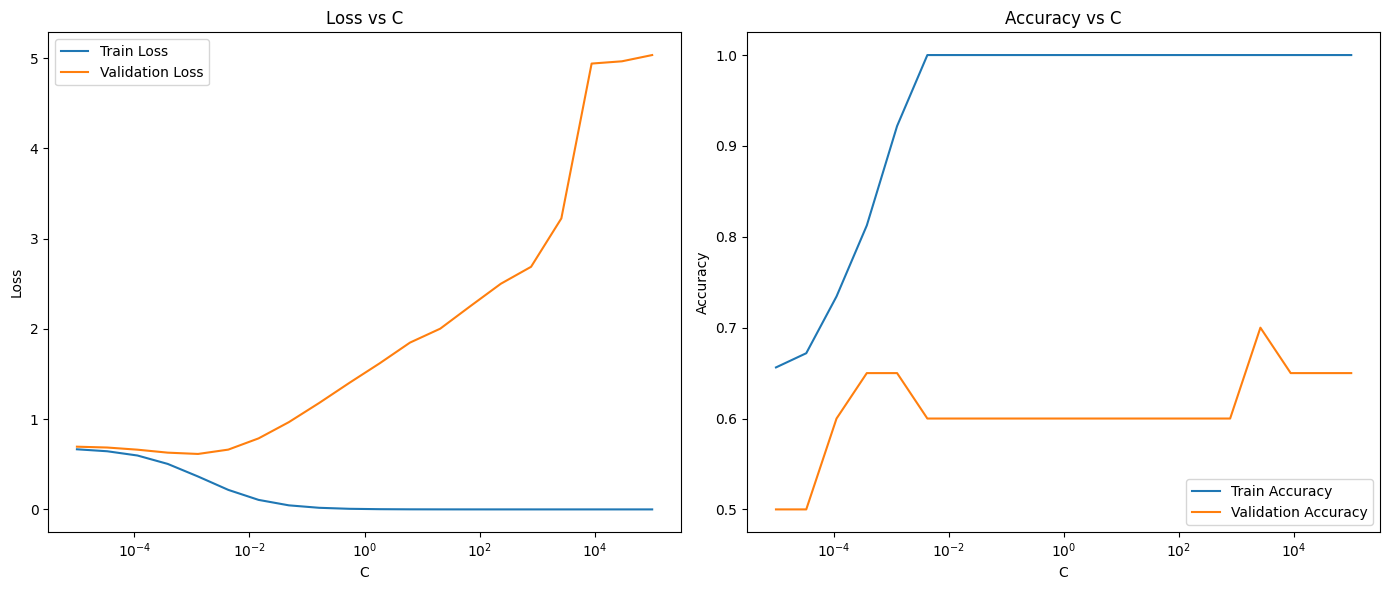

In [34]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss

# Assuming X_train, X_valid, y_train, and y_valid are defined

eps = 1e-6
Cs = np.logspace(-5, 5, 20)
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for i, C in enumerate(Cs):
    f_mean = X_train.mean(axis=0, keepdims=True)
    f_std = X_train.std(axis=0, keepdims=True) + eps  # epsilon to avoid dividing by 0
    X_train_tfm2 = (X_train - f_mean) / f_std
    X_valid_tfm2 = (X_valid - f_mean) / f_std
    
    classifier = LogisticRegression(penalty='l2', C=C, n_jobs=-1)
    classifier.fit(X_train_tfm2, y_train)
    
    train_probas = classifier.predict_proba(X_train_tfm2)
    valid_probas = classifier.predict_proba(X_valid_tfm2)
    
    train_loss = log_loss(y_train, train_probas)
    valid_loss = log_loss(y_valid, valid_probas)
    
    train_score = accuracy_score(y_train, classifier.predict(X_train_tfm2))
    val_score = accuracy_score(y_valid, classifier.predict(X_valid_tfm2))
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_score)
    valid_accuracies.append(val_score)
    
    print('{:2} eps: {:.2E}  C: {:.2E}  loss: {:.5f}  train_acc: {:.5f}  valid_acc: {:.5f}'.format(
        i, eps, C, train_loss, train_score, val_score))

# Plotting the results
plt.figure(figsize=(14, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(Cs, train_losses, label='Train Loss')
plt.plot(Cs, valid_losses, label='Validation Loss')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Loss')
plt.title('Loss vs C')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(Cs, train_accuracies, label='Train Accuracy')
plt.plot(Cs, valid_accuracies, label='Validation Accuracy')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('Accuracy vs C')
plt.legend()

plt.tight_layout()
plt.show()